In [1]:
! pip install opencv-python torch torchvision numpy matplotlib pillow

  Using cached opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached torch-2.7.1-cp312-none-macosx_11_0_arm64.whl.metadata (29 kB)
  Using cached torchvision-0.22.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached numpy-2.3.1-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached pillow-11.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached numpy-2.2.6-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.5.1-

In [ ]:
import cv2 
import os
import glob
import torch
import tarfile
import numpy as np
import hashlib
from torchvision.transforms import ToTensor
import shutil
import torchvision
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image

image_to_tensor = torchvision.transforms.ToTensor()
tensor_to_image = torchvision.transforms.ToPILImage()

In [ ]:
def mp4_to_jpg(video_path):
    video_name = Path(video_path).stem  
    output_dir = Path('frames') / video_name
    output_dir.mkdir(parents=True, exist_ok=True)

    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0

    while success:
        filename = f'frames/{video_name}/{count:04d}.jpg'
        cv2.imwrite(filename, image)
        success, image = vidcap.read()
        count += 1


In [12]:
def jpg_to_zip(video_name):
    frame_dir = Path('frames') / video_name
    with tarfile.open(f'../data/{video_name}.tar.gz', 'w:gz') as tar:
        for filename in os.listdir(frame_dir):
            tar.add(os.path.join(frame_dir, filename), arcname=filename)

In [ ]:
mp4_to_jpg('../data/CV_TrialRun_1_VialsNoColor_v1.mp4')

In [ ]:
jpg_to_zip('CV_TrialRun_1_VialsNoColor_v1')

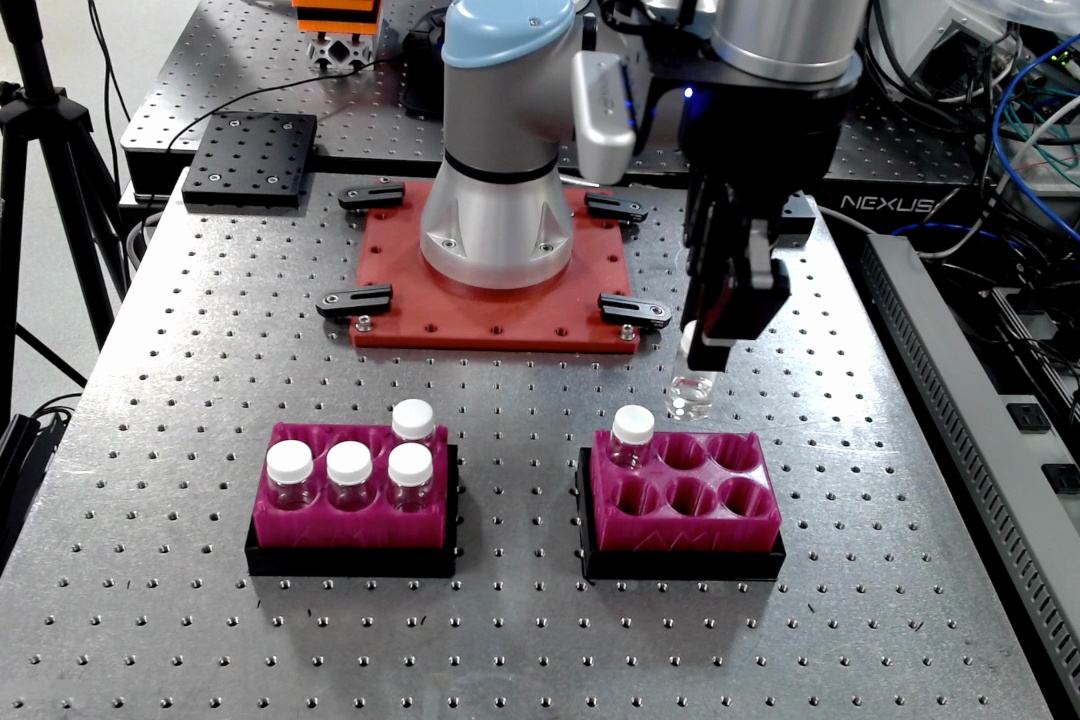

In [68]:
frame = Image.open('./frames/CV_TrialRun_1_VialsNoColor_v1/0830.jpg')
frame

In [76]:
frame.getpixel

<bound method Image.getpixel of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x720 at 0x1545AA3F0>>

In [69]:
vial_mask = torch.load('../data/mask0_vialswithcolor_every10th_subset.pt')
vial_mask.shape, vial_mask.dtype

(torch.Size([700, 1, 720, 1080]), torch.bool)

In [70]:
vial_mask = vial_mask.float()
vial_mask.dtype

torch.float32

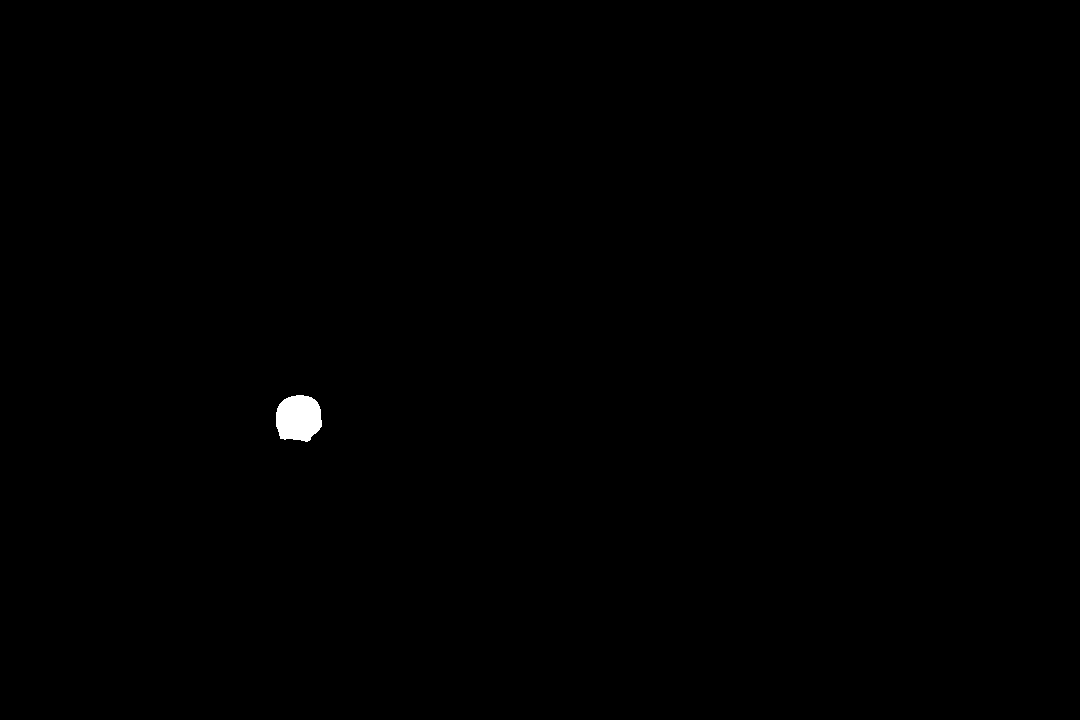

In [71]:
tensor_to_image(vial_mask[0])

In [72]:
mask_tensor = vial_mask[0]
frame_tensor = image_to_tensor(frame)

frame_tensor.shape, mask_tensor.shape

(torch.Size([3, 720, 1080]), torch.Size([1, 720, 1080]))

In [73]:
overlay = (frame_tensor + mask_tensor) / 2
overlay.shape

torch.Size([3, 720, 1080])

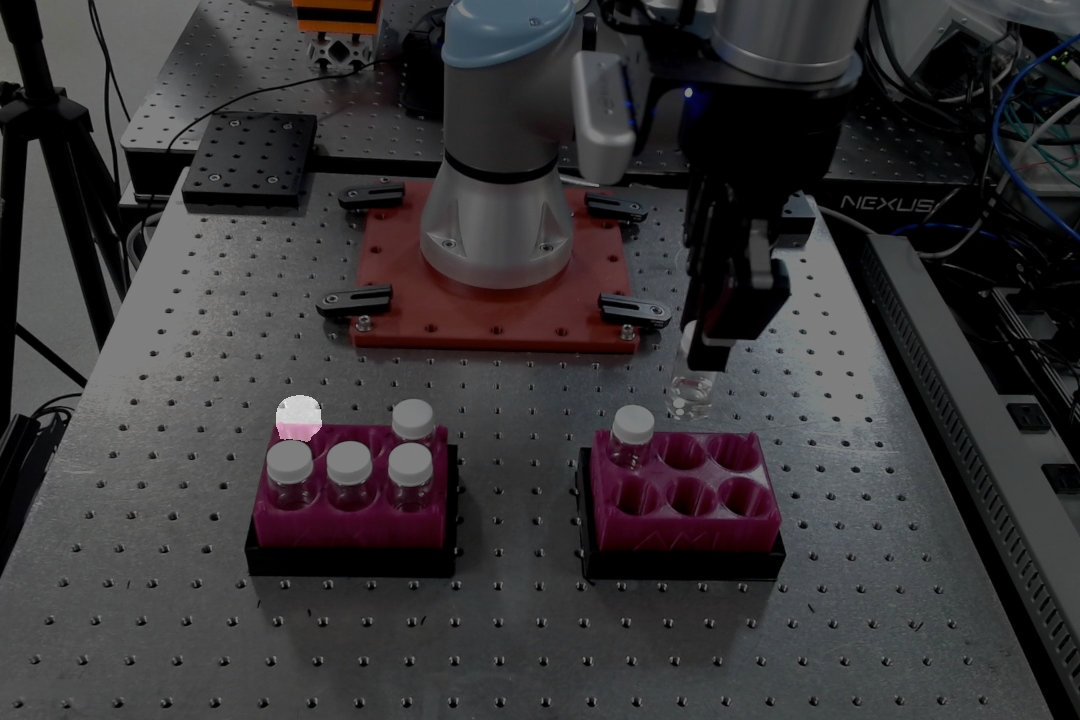

In [74]:
tensor_to_image(overlay)

## Resize Frames (256,256)

In [84]:
def resize_frames(frames_path, output_dir, size=(256, 256)):
    os.makedirs(output_dir, exist_ok=True)
    frame_files = sorted(glob.glob(os.path.join(frames_path, '*.jpg')))  
    for idx, frame_file in enumerate(frame_files):
        frame = cv2.imread(frame_file)
        if frame is None:
            print(f"Warning: Could not read {frame_file}")
            continue
        frame_resized = cv2.resize(frame, size, interpolation=cv2.INTER_LINEAR)
        out_path = os.path.join(output_dir, f"{idx:04d}.jpg")
        cv2.imwrite(out_path, frame_resized)

In [85]:
resize_frames(frames_path='./frames/CV_TrialRun_1_VialsNoColor_v1',
              output_dir='./frames_resized/CVTrialRun_1_VialsNoColor_v1')

In [166]:
def resize_mask_tensors(masks_path, output_dir, size=(256, 256)):
    os.makedirs(output_dir, exist_ok=True)
    mask_files = sorted(glob.glob(os.path.join(masks_path, '*.pt')))
    
    for idx, mask_file in enumerate(mask_files):
        print(f"Current Mask file: {mask_file}")
        counter = 0 
        mask_batch = torch.load(mask_file)  # shape: (N, 1, H, W)
        
        if mask_batch.ndim != 4:
            raise ValueError(f"Expected shape (N, 1, H, W), got {mask_batch.shape}")
        
        for i in range(mask_batch.shape[0]):
            mask_tensor = mask_batch[i]  # shape: (1, H, W)
            mask_np = mask_tensor.squeeze(0).cpu().numpy()  # shape: (H, W)

            if mask_np.dtype == np.bool_:
                mask_np = mask_np.astype(np.uint8)

            if mask_np.size == 0:
                print(f"Skipping empty mask in file {mask_file}, index {i}")
                continue

            # Resize using nearest neighbor
            mask_resized = cv2.resize(mask_np, size, interpolation=cv2.INTER_NEAREST)

            # Convert back to tensor and add channel
            mask_resized_tensor = torch.from_numpy(mask_resized).unsqueeze(0)  # shape: (1, H, W)

            out_path = os.path.join(output_dir, f"mask{idx}_{counter:04d}.pt")
            torch.save(mask_resized_tensor, out_path)
            counter += 1


In [167]:
resize_mask_tensors(masks_path='../data/masks',
              output_dir='../data/masks_resized',
              size=(256,256))

Current Mask file: ../data/masks/mask0_vialswithcolor_every10th_subset.pt
Current Mask file: ../data/masks/mask1_vialswithcolor_every10th_subset.pt
Current Mask file: ../data/masks/mask2_vialswithcolor_every10th_subset.pt
Current Mask file: ../data/masks/mask3_vialswithcolor_every10th_subset.pt
Current Mask file: ../data/masks/mask4_vialswithcolor_every10th_subset.pt
Current Mask file: ../data/masks/mask5_vialswithcolor_every10th_subset.pt


In [ ]:
def hash_tensor(tensor):
    return hashlib.sha256(tensor.cpu().numpy().tobytes()).hexdigest()

def save_unique_masks_per_group(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    mask_files = sorted(glob.glob(os.path.join(input_folder, 'mask*.pt')))
    unique_hashes = defaultdict(dict)
    counters = defaultdict(int)

    for path in mask_files:
        filename = os.path.basename(path)
        group = filename.split('_')[0]  # e.g., "mask2"

        try:
            mask = torch.load(path)

            if mask.ndim == 3 and mask.shape[0] == 1:
                mask = mask.squeeze(0)

            hash_val = hash_tensor(mask)

            # Save first occurrence of unique mask
            if hash_val not in unique_hashes[group]:
                unique_hashes[group][hash_val] = path

                # Save with group-specific counter
                out_filename = f"{group}_{counters[group]:04d}.pt"
                out_path = os.path.join(output_folder, out_filename)

                # Reshape to (1, H, W) before saving (optional)
                mask_to_save = mask.unsqueeze(0) if mask.ndim == 2 else mask
                torch.save(mask_to_save, out_path)

                counters[group] += 1

        except Exception as e:
            print(f"Error reading {path}: {e}")

    print("\nDone! Unique mask counts:")
    for group in sorted(counters):
        print(f"{group}: {counters[group]} unique masks saved.")

save_unique_masks_per_group(
    input_folder='../data/masks_resized',
    output_folder='../data/masks_unique'
)



Done! Unique mask counts:
mask0: 367 unique masks saved.
mask1: 328 unique masks saved.
mask2: 281 unique masks saved.
mask3: 317 unique masks saved.
mask4: 181 unique masks saved.
mask5: 318 unique masks saved.


Unique mask counts per group:

mask0: 367 unique / 700 total
mask1: 328 unique / 700 total
mask2: 281 unique / 700 total
mask3: 317 unique / 700 total
mask4: 181 unique / 700 total
mask5: 318 unique / 700 total

🎲 Sampling 2 unique masks from 'mask3'...


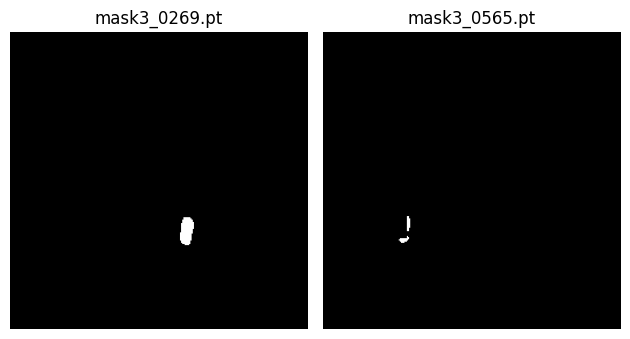

In [ ]:
def hash_tensor(tensor):
    return hashlib.sha256(tensor.cpu().numpy().tobytes()).hexdigest()

def count_and_sample_unique_masks(folder_path, group_to_sample='mask0', num_samples=2):
    mask_files = sorted(glob.glob(os.path.join(folder_path, 'mask*.pt')))
    unique_hashes = defaultdict(dict)
    total_counts = defaultdict(int)

    for path in mask_files:
        filename = os.path.basename(path)
        group = filename.split('_')[0]

        try:
            mask = torch.load(path)
            if mask.ndim == 3 and mask.shape[0] == 1:
                mask = mask.squeeze(0)

            h = hash_tensor(mask)
            total_counts[group] += 1

            # Only keep first occurrence of each unique hash
            if h not in unique_hashes[group]:
                unique_hashes[group][h] = path

        except Exception as e:
            print(f"Error reading {path}: {e}")

    # Print unique counts
    print("Unique mask counts per group:\n")
    for group in sorted(unique_hashes):
        total = total_counts[group]
        unique = len(unique_hashes[group])
        print(f"{group}: {unique} unique / {total} total")

    # Random sample from the specified group
    if group_to_sample not in unique_hashes:
        print(f"\nGroup '{group_to_sample}' not found.")
        return

    print(f"\n🎲 Sampling {num_samples} unique masks from '{group_to_sample}'...")
    sampled_paths = random.sample(list(unique_hashes[group_to_sample].values()), k=num_samples)

    # Plot the sampled masks
    for i, path in enumerate(sampled_paths):
        mask = torch.load(path)
        if mask.ndim == 3 and mask.shape[0] == 1:
            mask = mask.squeeze(0)
        mask_np = mask.cpu().numpy()

        plt.subplot(1, num_samples, i+1)
        plt.imshow(mask_np, cmap='gray')
        plt.title(os.path.basename(path))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

count_and_sample_unique_masks('../data/masks_resized', group_to_sample='mask3', num_samples=2)

In [21]:
resized_vial_mask = torch.load('../data/masks_unique/mask0_0023.pt')
resized_vial_mask.shape, resized_vial_mask.dtype

(torch.Size([1, 256, 256]), torch.uint8)

In [22]:
resized_vial_mask = resized_vial_mask.float()
resized_vial_mask.dtype

torch.float32

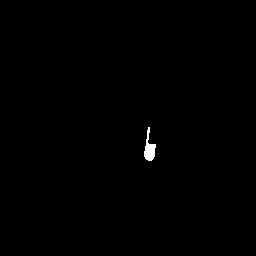

In [23]:
tensor_to_image(resized_vial_mask[0])

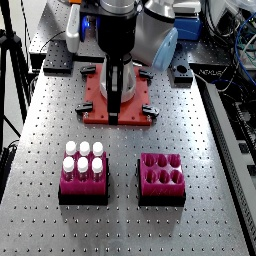

In [24]:
resized_frame = Image.open('./frames_resized/CVTrialRun_1_VialsNoColor_v1/0000.jpg')
resized_frame

In [25]:
resized_mask_tensor = resized_vial_mask[0]
resized_frame_tensor = image_to_tensor(resized_frame)

resized_frame_tensor.shape, resized_mask_tensor.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [26]:
overlay = (resized_frame_tensor + resized_mask_tensor) / 2
overlay.shape

torch.Size([3, 256, 256])

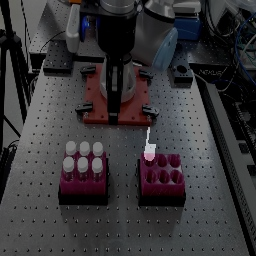

In [27]:
tensor_to_image(overlay)

## Data Loader

In [ ]:
# class MaskDataset(Dataset):
#     def __init__(self, mask_dir, groups=None, transform=None):
#         self.mask_dir = mask_dir
#         self.transform = transform

#         all_files = sorted(glob.glob(os.path.join(mask_dir, 'mask*.pt')))

#         if groups is not None:
#             self.files = [
#                 f for f in all_files if os.path.basename(f).split('_')[0] in groups
#             ]
#         else:
#             self.files = all_files

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, idx):
#         path = self.files[idx]
#         mask = torch.load(path)

#         # Ensure shape is (1, H, W)
#         if mask.ndim == 2:
#             mask = mask.unsqueeze(0)

#         if self.transform:
#             mask = self.transform(mask)

#         return mask, os.path.basename(path)

In [ ]:
# # Example: Load only mask3 masks
# dataset = MaskDataset(
#     mask_dir='../data/masks_unique',
#     groups=['mask3'],
# )

# loader = DataLoader(dataset, batch_size=8, shuffle=True)

# # Iterate through loader
# for batch in loader:
#     masks, filenames = batch
#     print("Batch shape:", masks.shape)  # (B, 1, H, W)
#     print("Filenames:", filenames)
#     break


Batch shape: torch.Size([8, 1, 256, 256])
Filenames: ('mask3_0007.pt', 'mask3_0058.pt', 'mask3_0126.pt', 'mask3_0109.pt', 'mask3_0179.pt', 'mask3_0103.pt', 'mask3_0312.pt', 'mask3_0219.pt')


In [ ]:
# class FrameMaskVideoDataset(Dataset):
#     def __init__(self, frames_dir, masks_dir, clip_len=8, transform=None, mask_prefix=None):
#         self.frames_dir = frames_dir
#         self.masks_dir = masks_dir
#         self.clip_len = clip_len
#         self.transform = transform or ToTensor()
#         self.mask_prefix = mask_prefix
#         self.samples = self._build_index() # num of clips found

#     def _build_index(self): 
#         frame_files = sorted(glob.glob(os.path.join(self.frames_dir, "*.jpg")))
#         samples = []

#         for i in range(0, len(frame_files) - self.clip_len + 1):
#             clip_frames = frame_files[i:i + self.clip_len]

#             # Extract indices from filenames like frame_0001.jpg → 0001
#             frame_indices = [
#                 re.search(r"(\d+)", os.path.basename(fp)).group(1) for fp in clip_frames
#             ]

#             # For each index, find all matching mask files (e.g., mask1_0001.pt, mask2_0001.pt, ...)
#             clip_mask_groups = []
#             for idx in frame_indices:
#                 matching_masks = sorted(glob.glob(os.path.join(self.masks_dir, f"*_{idx}.pt")))
#                 if not matching_masks:
#                     break  # skip this clip if *any* frame is missing masks
#                 clip_mask_groups.append(matching_masks)

#             if len(clip_mask_groups) == self.clip_len:
#                 samples.append((clip_frames, clip_mask_groups))

#         return samples

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         frame_paths, all_mask_paths = self.samples[idx]

#         # Load frames
#         frames = [self.transform(Image.open(fp)) for fp in frame_paths]
#         frames_tensor = torch.stack(frames, dim=1)  # [C, T, H, W]

#         # Load all masks for each frame
#         # Output shape: [T, N, H, W]  (T=frames, N=masks per frame)
#         all_masks = []
#         for mask_group in all_mask_paths:
#             masks = [torch.load(mp).squeeze(0).float() for mp in mask_group]
#             stacked = torch.stack(masks, dim=0)  # [N, H, W]
#             all_masks.append(stacked)

#         masks_tensor = torch.stack(all_masks, dim=0)  # [T, N, H, W]

#         return {
#             'frame': frames_tensor,     # [3, T, H, W]
#             'modal_mask': masks_tensor       # [T, N, H, W]
#         }

In [ ]:
# dataset = FrameMaskVideoDataset(
#     frames_dir="./frames_resized/CVTrialRun_1_VialsNoColor_v1",
#     masks_dir="../data/masks_resized",
#     clip_len=10,
#     mask_prefix=None
# )

# sample = dataset[0]
# print(sample['frame'].shape)  # torch.Size([3, 10, H, W]) ([RGB, n_frames in the clip, height, width])
# print(sample['modal_mask'].shape)   # torch.Size([10, M/F, H, W]) ([n_frames, masks/frame, height, width])
# # 6 masks per frame

torch.Size([3, 10, 256, 256])
torch.Size([10, 6, 256, 256])


[3, 10, 256, 256]  # 3 channels, 10 frames, 256x256 pixels
[10, 6, 256, 256]  # 10 frames, 6 masks per frame, 256x256 pixels

Output shape: torch.Size([1, 8, 10, 128, 128])
Output min: -1.2542588710784912
Output max: 1.0451679229736328
Output mean: 0.06362941116094589
Output std: 0.318975567817688


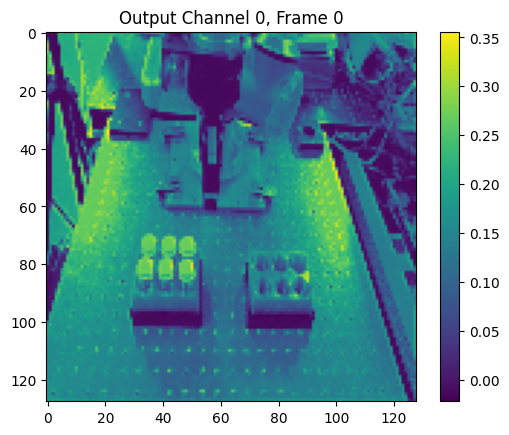

In [ ]:
# # Dummy 3D CNN model example
# class Simple3DCNN(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # input: (batch, channels=3, time=10, H=256, W=256)
#         self.conv3d = nn.Conv3d(in_channels=3, out_channels=8, kernel_size=(3, 3, 3), padding=1)
#         self.pool = nn.MaxPool3d((1, 2, 2))  # pool only spatial dims

#     def forward(self, x):
#         x = self.conv3d(x)  # [B, 8, 10, 256, 256]
#         x = self.pool(x)    # [B, 8, 10, 128, 128]
#         return x

# # Assume your sample tensors are:
# frames = sample['frame']      # your real input here
# modal_masks = sample['modal_mask']  # your real masks

# # Rearrange frames tensor to (batch, channels, time, H, W)
# frames = frames.unsqueeze(0)  # add batch dim → [1, 3, 10, 256, 256]

# model = Simple3DCNN()
# output = model(frames)

# print("Output shape:", output.shape)
# print("Output min:", output.min().item())
# print("Output max:", output.max().item())
# print("Output mean:", output.mean().item())
# print("Output std:", output.std().item())

# out_slice = output[0, 0, 0].detach().cpu()

# plt.imshow(out_slice, cmap='viridis')
# plt.colorbar()
# plt.title('Output Channel 0, Frame 0')
# plt.show()